In [12]:
# Notebook init
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os, sys; sys.path.insert(0, os.path.join(os.getcwd(), '../..'))
print(sys.path)

import data_pipelines.util as data_util

# Disable fetching new data?  Assign no_update.
import data_pipelines
#data_pipelines.settings.no_update = True

import seaborn as sns

['/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW/../..', '/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW/../..', '/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW/../..', '/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW/../..', '/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW/../..', '', '/Users/ericdavis/Galois/covid-19-staging/sandbox/COVID-19_WW', '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python37.zip', '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7', '/usr/local/Cellar/python/3.7.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/site-packages', '/usr/local/lib/python3.7/site-packages/IPython/extensions', '/Users/ericdavis/.ipython']


In [5]:
# Data pipeline fetching
import data_pipelines.county_descarteslabs_mobility as mobility
import data_pipelines.county_nytimes_covid_stats as covid
import data_pipelines.county_usda_census as census
import data_pipelines.state_covidtracking_com_covid_testing as testing

df_m = mobility.get()
df_c = covid.get()
df_p = census.get()['population']
df_t = testing.get()

In [6]:
df_m_j = df_m.loc[pd.notna(df_m['county']) & pd.notna(df_m['date'])]
df_c_j = df_c.loc[pd.notna(df_c['county']) & pd.notna(df_c['date'])]
df_p_j = df_p.loc[pd.notna(df_p['county'])]
df_t_j = df_t.loc[pd.notna(df_t['state'])]

# Roll population data into NYTimes
df_p_j['population'] = df_p_j['POP_ESTIMATE_latest']
df_p_j = df_p_j[['county', 'population']]
df_c_j = df_c_j.set_index(['county']).join(df_p_j.set_index('county')).reset_index()

# Roll testing data into NYTimes
t_data = df_t_j[['state', 'date', 'positive', 'negative', 'pending']]
t_data = t_data.rename({'positive': 'testing_positive', 'negative': 'testing_negative', 
                        'pending': 'testing_pending'}, 
                       axis=1)
t_data['testing_pending'].fillna(0, inplace=True)
t_data['testing_total'] = t_data['testing_positive'] + t_data['testing_negative'] + t_data['testing_pending']
df_c_j = df_c_j.merge(t_data, on=('state', 'date')).reset_index()

# Default join is left.  We want to maximize available case data, regardless of m50
df = df_m_j.set_index(['county', 'date']).join(df_c_j.set_index(['county', 'date']), 
        how='right', rsuffix='_c')
import dateutil.parser
df = df.reset_index()
df['date'] = df['date'].map(lambda x: dateutil.parser.parse(x))
df = df.set_index(['county', 'date'])

In [7]:
df

country_code  admin_level   admin1          admin2  samples  \
county date                                                                     
01001  2020-03-24           US          2.0  Alabama  Autauga County   1758.0   
       2020-03-25           US          2.0  Alabama  Autauga County   1752.0   
       2020-03-26           US          2.0  Alabama  Autauga County   1757.0   
       2020-03-27           US          2.0  Alabama  Autauga County   1725.0   
       2020-03-28           US          2.0  Alabama  Autauga County   1735.0   
       2020-03-29           US          2.0  Alabama  Autauga County   1740.0   
       2020-03-30           US          2.0  Alabama  Autauga County   1750.0   
       2020-03-31           US          2.0  Alabama  Autauga County   1748.0   
       2020-04-01           US          2.0  Alabama  Autauga County   1750.0   
       2020-04-02          NaN          NaN      NaN             NaN      NaN   
01003  2020-03-14           US          2.0  Alabama  Baldwin County   8349.0   
       2020-03-15           US          2.0  Alabama  Baldwin County   8802.0   
       2020-03-16           US          2.0  Alabama  Baldwin County   8735.0   
       2020-03-17           US          2.0  Alabama  Baldwin County   9144.0   
       2020-03-18           US          2.0  Alabama  Baldwin County   8804.0   
       2020-03-19           US          2.0  Alabama  Baldwin County   8288.0   
       2020-03-20           US          2.0  Alabama  Baldwin County   7615.0   
       2020-03-21           US          2.0  Alabama  Baldwin County   5740.0   
       2020-03-22           US          2.0  Alabama  Baldwin County   6514.0   
       2020-03-23           US          2.0  Alabama  Baldwin County   6827.0   
       2020-03-24           US          2.0  Alabama  Baldwin County   6991.0   
       2020-03-25           US          2.0  Alabama  Baldwin County   6725.0   
       2020-03-26           US          2.0  Alabama  Baldwin County   6790.0   
       2020-03-27           US          2.0  Alabama  Baldwin County   6792.0   
       2020-03-28           US          2.0  Alabama  Baldwin County   6762.0   
       2020-03-29           US          2.0  Alabama  Baldwin County   7085.0   
       2020-03-30           US          2.0  Alabama  Baldwin County   6787.0   
       2020-03-31           US          2.0  Alabama  Baldwin County   6827.0   
       2020-04-01           US          2.0  Alabama  Baldwin County   6723.0   
       2020-04-02          NaN          NaN      NaN             NaN      NaN   
...                        ...          ...      ...             ...      ...   
72999  2020-03-22          NaN          NaN      NaN             NaN      NaN   
       2020-03-23          NaN          NaN      NaN             NaN      NaN   
       2020-03-24          NaN          NaN      NaN             NaN      NaN   
       2020-03-25          NaN          NaN      NaN             NaN      NaN   
       2020-03-26          NaN          NaN      NaN             NaN      NaN   
       2020-03-27          NaN          NaN      NaN             NaN      NaN   
       2020-03-28          NaN          NaN      NaN             NaN      NaN   
       2020-03-29          NaN          NaN      NaN             NaN      NaN   
       2020-03-30          NaN          NaN      NaN             NaN      NaN   
       2020-03-31          NaN          NaN      NaN             NaN      NaN   
       2020-04-01          NaN          NaN      NaN             NaN      NaN   
       2020-04-02          NaN          NaN      NaN             NaN      NaN   
78999  2020-03-16          NaN          NaN      NaN             NaN      NaN   
       2020-03-17          NaN          NaN      NaN             NaN      NaN   
       2020-03-18          NaN          NaN      NaN             NaN      NaN   
       2020-03-19          NaN          NaN      NaN             NaN      NaN   
       2020-03-20          NaN          NaN      

In [8]:
df.loc[data_util.resolve_county('multnomah', 'or')]

,country_code,admin_level,admin1,admin2,samples,m50,m50_index,state,index,state_c,cases,deaths,population,testing_positive,testing_negative,testing_pending,testing_total
date,,,,,,,,,,,,,,,,,
2020-03-10,US,2.0,Oregon,Multnomah County,9210.0,4.924,98.0,OR,20401,OR,1,0,811880.0,15.0,213.0,67.0,295.0
2020-03-11,US,2.0,Oregon,Multnomah County,9247.0,4.780,95.0,OR,20383,OR,1,0,811880.0,19.0,286.0,62.0,367.0
2020-03-12,US,2.0,Oregon,Multnomah County,9154.0,5.006,99.0,OR,20339,OR,1,0,811880.0,19.0,286.0,62.0,367.0
2020-03-13,US,2.0,Oregon,Multnomah County,9005.0,4.490,89.0,OR,20350,OR,1,0,811880.0,30.0,337.0,157.0,524.0
2020-03-14,US,2.0,Oregon,Multnomah County,8512.0,1.506,29.0,OR,20361,OR,1,1,811880.0,30.0,337.0,157.0,524.0
2020-03-15,US,2.0,Oregon,Multnomah County,8477.0,1.287,25.0,OR,20372,OR,1,1,811880.0,36.0,420.0,225.0,681.0
2020-03-16,US,2.0,Oregon,Multnomah County,8446.0,2.861,56.0,OR,19982,OR,2,1,811880.0,39.0,579.0,182.0,800.0
2020-03-17,US,2.0,Oregon,Multnomah County,8911.0,2.015,40.0,OR,19996,OR,3,1,811880.0,47.0,689.0,184.0,920.0
2020-03-18,US,2.0,Oregon,Multnomah County,8490.0,1.890,37.0,OR,20010,OR,3,1,811880.0,75.0,1118.0,361.0,1554.0


In [9]:
df.loc[data_util.resolve_county('new york', 'ny')]

,country_code,admin_level,admin1,admin2,samples,m50,m50_index,state,index,state_c,cases,deaths,population,testing_positive,testing_negative,testing_pending,testing_total
date,,,,,,,,,,,,,,,,,
2020-03-04,US,2.0,New York,New York County,16326.0,2.023,102.0,NY,17402,NY,2,0,1628701.0,6.0,48.0,24.0,78.0
2020-03-05,US,2.0,New York,New York County,15078.0,2.046,104.0,NY,17370,NY,4,0,1628701.0,22.0,76.0,24.0,122.0
2020-03-06,US,2.0,New York,New York County,15300.0,1.966,100.0,NY,17373,NY,5,0,1628701.0,33.0,92.0,236.0,361.0
2020-03-07,US,2.0,New York,New York County,15464.0,1.016,51.0,NY,17377,NY,12,0,1628701.0,76.0,92.0,236.0,404.0
2020-03-08,US,2.0,New York,New York County,15803.0,0.606,30.0,NY,17382,NY,14,0,1628701.0,105.0,92.0,0.0,197.0
2020-03-09,US,2.0,New York,New York County,16172.0,1.953,99.0,NY,17389,NY,20,0,1628701.0,142.0,92.0,0.0,234.0
2020-03-10,US,2.0,New York,New York County,15862.0,1.713,87.0,NY,17396,NY,37,0,1628701.0,173.0,92.0,0.0,265.0
2020-03-11,US,2.0,New York,New York County,15676.0,1.855,94.0,NY,17363,NY,52,0,1628701.0,216.0,92.0,0.0,308.0
2020-03-12,US,2.0,New York,New York County,15536.0,1.614,82.0,NY,16449,NY,96,0,1628701.0,216.0,92.0,0.0,308.0


In [10]:
df.loc[data_util.resolve_county('palm beach', 'fl')][['m50_index', 'cases']].reset_index()

,date,m50_index,cases
0,2020-03-12,99.0,2
1,2020-03-13,99.0,5
2,2020-03-14,69.0,5
3,2020-03-15,48.0,5
4,2020-03-16,73.0,7
5,2020-03-17,66.0,11
6,2020-03-18,53.0,20
7,2020-03-19,55.0,28
8,2020-03-20,62.0,41
9,2020-03-21,26.0,56


Text(0.01,0.99,"Above are plots re: mobility (proxy for policy) and number\nof reported cases, normalized by population.  Green lines of \nstate testing indicate case count is unreliable, as testing hasn't\nkept up.\n\nLeft are plots demonstrating volume of tests, and percent of all \ntests coming back positive.\n\nIt's pretty clear that testing hasn't caught up to rate of spread, \nlimiting the utility of projections based on disease counts. \n")

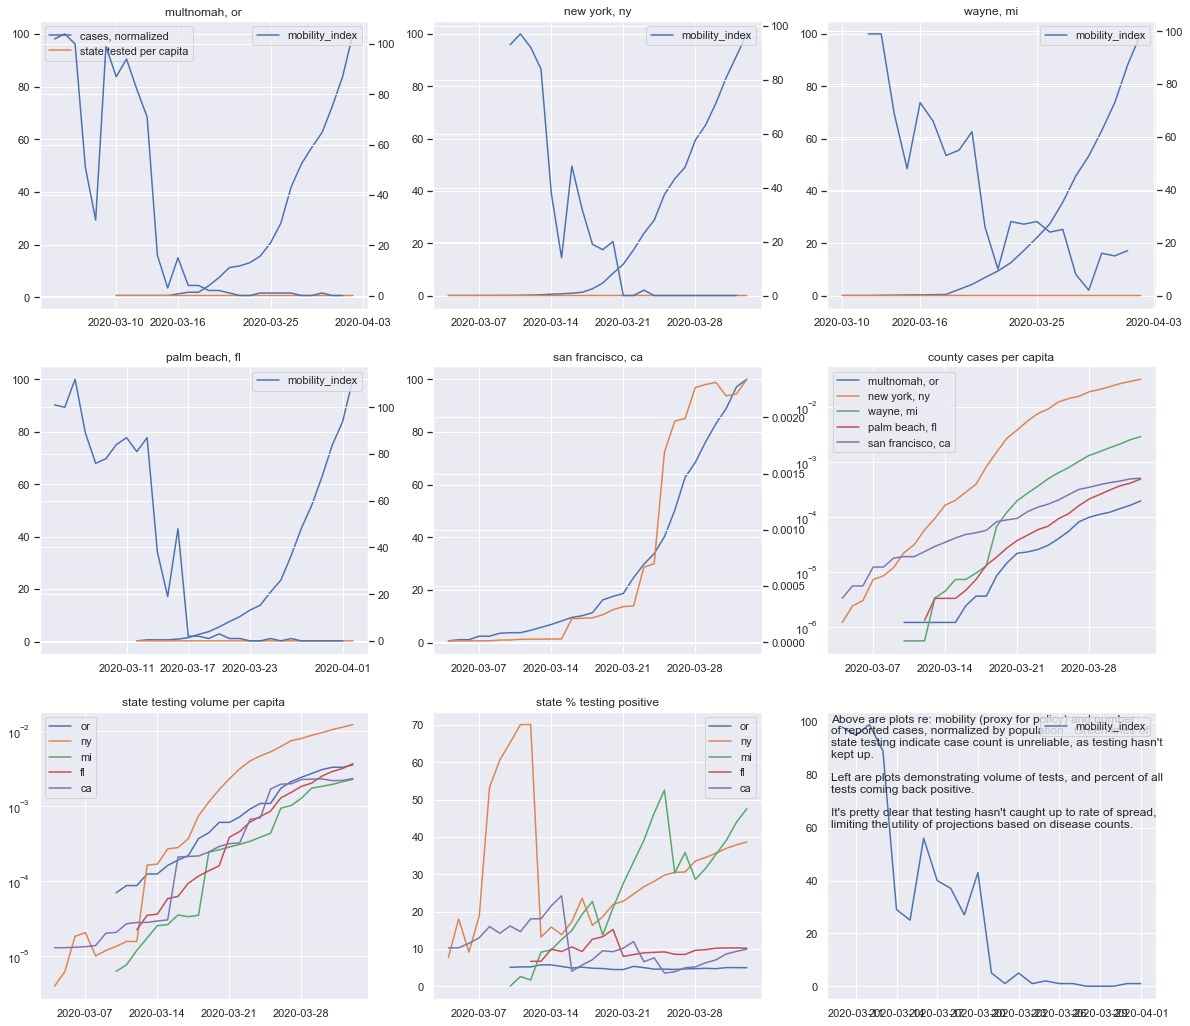

In [21]:
sns.set()

sites = [['multnomah', 'or'], ['new york', 'ny'], ['wayne', 'mi'], ['palm beach', 'fl'], 
         # Volusia, FL contains Daytona beach
         #['volusia', 'fl'],
         ['san francisco', 'ca'],
]
cols = 3
rows = int(np.ceil((4 + len(sites)) / cols))
f, axs2d = plt.subplots(rows, cols, figsize=(20, 6 * rows), squeeze=False)
nticks = 4
def reduce_ticks(ax, axis_name, count):
    ticks = getattr(ax, f'get_{axis_name}ticks')()
    ticks = [ticks[i] for i in np.linspace(0, len(ticks) - 1, count, dtype=int)]
    getattr(ax, f'set_{axis_name}ticks')(ticks)
axs = []
for a in axs2d:
    axs.extend(a)
df_state_pop = df_p[['county', 'POP_ESTIMATE_latest']].set_index('county')
for s, ax in zip(sites, axs):
    ax.set_title(', '.join(s))
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    
    sns.lineplot(d['date'].values, d['m50_index'].values, label='mobility_index')
    ax.plot(d['date'].values, (100 * d['cases'] / d['cases'].max()).values, label='cases, normalized')
    
    # Testing is per-state, so normalize against state-wide population
    state_pop = df_state_pop.loc[data_util.resolve_county('all', s[1])]['POP_ESTIMATE_latest']
    tested_pop = d['testing_total']
    # Dummy for legend
    fake = ax.plot(d['date'].values[:1], d['cases'].values[:1], label='state tested per capita')
    ax2 = ax.twinx()
    ax2.plot(d['date'].values, (tested_pop / state_pop).values,
            color=fake[0].get_color())
    reduce_ticks(ax, 'x', nticks)
axs[0].legend()
    
# Combined
ax = axs[len(sites)]
ax.set_title('county cases per capita')
ax.set_yscale('log')
for s in sites:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    cases_per = d['cases'] / d['population']
    ax.plot(d['date'].values, cases_per.values, label=', '.join(s))
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Testing volume (state-level)
ax = axs[len(sites)+1]
ax.set_title('state testing volume per capita')
ax.set_yscale('log')
sites_no_dup_states = [s for i, s in enumerate(sites) if s[1] not in [v[1] for v in sites[:i]]]
for s in sites_no_dup_states:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    state_pop = df_state_pop.loc[data_util.resolve_county('all', s[1])]['POP_ESTIMATE_latest']
    ax.plot(d['date'].values, (d['testing_total'] / state_pop).values, label=s[1])
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Testing rates
ax = axs[len(sites)+2]
ax.set_title('state % testing positive')
for s in sites_no_dup_states:
    d = df.loc[data_util.resolve_county(*s)].reset_index()
    testing_total = d['testing_total']
    testing_pct = 100 * d['testing_positive'] / d['testing_total']
    ax.plot(d['date'].values, testing_pct.values, label=s[1])
reduce_ticks(ax, 'x', nticks)
ax.legend()

# Notes
ax = axs[len(sites)+3]
ax.text(0.01, 0.99, 
        "Above are plots re: mobility (proxy for policy) and number\n\
of reported cases, normalized by population.  Green lines of \n\
state testing indicate case count is unreliable, as testing hasn't\n\
kept up.\n\
\n\
Left are plots demonstrating volume of tests, and percent of all \n\
tests coming back positive.\n\
\n\
It's pretty clear that testing hasn't caught up to rate of spread, \n\
limiting the utility of projections based on disease counts. \n\
", 
        transform=ax.transAxes, 
        horizontalalignment='left', verticalalignment='top')